In [1]:
# Re-import necessary libraries after state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [3]:
articles_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles.csv")
authors_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors.csv")
author_article_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles_authors.csv")
affiliations_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/affiliations.csv")
author_institution_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors_affiliations.csv")

In [4]:
target_institution = 'Escuela Politécnica Nacional'

In [5]:
author_links = author_article_links_df.merge(
    author_institution_links_df, on='author_id', how='left'
)

author_links = author_links.merge(
    affiliations_df, left_on='affiliation_id', right_on='identifier', how='left', suffixes=('', '_inst')
)

full_df = author_links.merge(
    articles_df, left_on='article_id', right_on='identifier', how='left', suffixes=('', '_article')
)

# 4. Extract year for grouping
full_df['pub_year'] = pd.to_datetime(full_df['publication_date'], errors='coerce').dt.year


# 5. Group by institution and year
inst_yearly_counts = (
    full_df.groupby(['affiliation_name', 'pub_year'])
    .agg(num_publications=('article_id', 'nunique'))
    .reset_index()
)

# Only keep institutions with at least 2 years of data
filtered_inst_yearly_counts = (
    inst_yearly_counts.groupby("affiliation_name")
    .filter(lambda x: x['pub_year'].nunique() >= 2)
)

ua_data = filtered_inst_yearly_counts[filtered_inst_yearly_counts['affiliation_name'] == target_institution]


In [6]:
# Split train and evaluation (last year for evaluation)
X = ua_data['pub_year'].values.reshape(-1, 1)
y = ua_data['num_publications'].values
X_train, y_train = X[:-1], y[:-1]
X_eval, y_eval = X[-1:], y[-1:]

In [7]:
# Future years for forecast
X_future = np.arange(2025, 2036).reshape(-1, 1)

In [8]:
# Collect results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_eval = model.predict(X_eval)
    future_preds = model.predict(X_future)

    mae = mean_absolute_error(y_eval, y_pred_eval)
    rmse = mean_squared_error(y_eval, y_pred_eval)

    results.append((name, y_pred_eval[0], mae, rmse, future_preds))

# Prepare a summary table
summary = pd.DataFrame(
    [(name, round(pred, 2), round(mae, 2), round(rmse, 2)) for name, pred, mae, rmse, _ in results],
    columns=["Model", "Last Year Prediction", "MAE", "RMSE"]
)

summary

,Model,Last Year Prediction,MAE,RMSE
0,Linear Regression,206.62,120.38,14491.57
1,Ridge Regression,206.61,120.39,14492.72
2,Lasso Regression,206.55,120.45,14507.02
3,Random Forest,649.32,322.32,103890.18
4,Gradient Boosting,614.92,287.92,82900.24


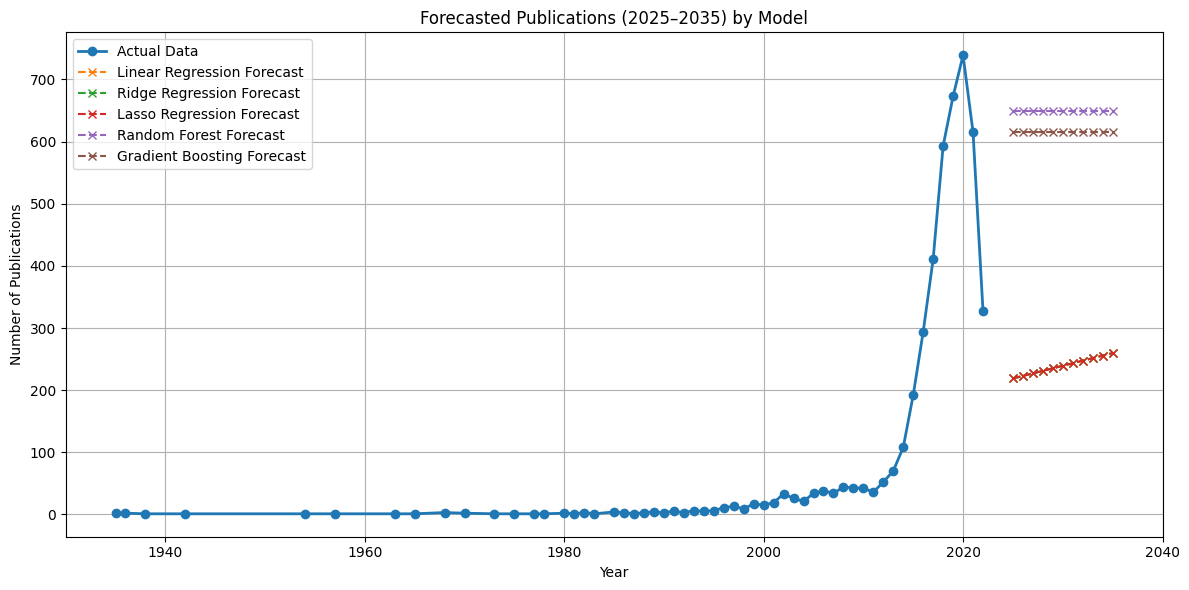

In [9]:
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(ua_data['pub_year'], ua_data['num_publications'], marker='o', label='Actual Data', linewidth=2)

# Plot forecast from each model
for name, _, _, _, future_preds in results:
    plt.plot(X_future, future_preds, linestyle='--', marker='x', label=f'{name} Forecast')

# Customize plot
plt.title("Forecasted Publications (2025–2035) by Model")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

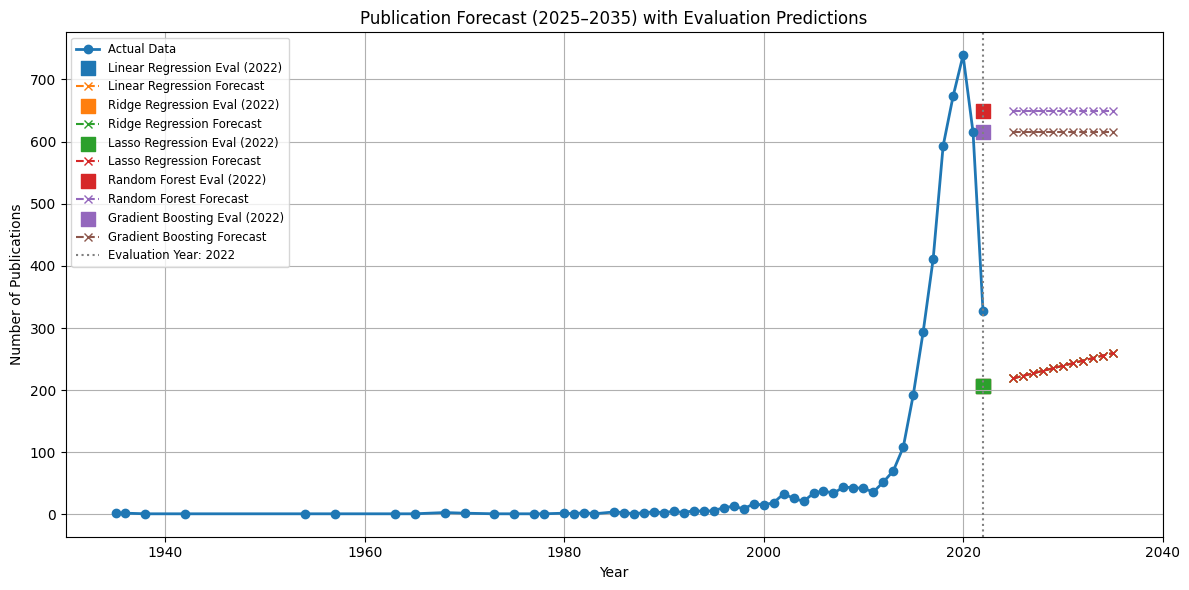

In [10]:
future_years = np.arange(2025, 2036)
evaluation_year = ua_data['pub_year'].max()  # Last year before prediction
evaluation_actual = ua_data[ua_data['pub_year'] == evaluation_year]['num_publications'].values[0]

# Start plot
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(ua_data['pub_year'], ua_data['num_publications'], marker='o', label='Actual Data', linewidth=2)

# Plot evaluation and forecast for each model
for name, y_eval_pred, _, _, future_preds in results:
    # Evaluation prediction
    plt.scatter(evaluation_year, y_eval_pred, marker='s', s=100, label=f'{name} Eval ({evaluation_year})')

    # Forecast prediction
    plt.plot(future_years, future_preds, linestyle='--', marker='x', label=f'{name} Forecast')

# Customize plot
plt.axvline(evaluation_year, color='gray', linestyle=':', label=f'Evaluation Year: {evaluation_year}')
plt.title("Publication Forecast (2025–2035) with Evaluation Predictions")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()